# supernode-features

The procedure of constructing supernode features of various kinds.

__Warning!__ Some procedures require 16 cores and up to 5 GB RAM.

Requires:
1. `data/supernodes/supernode_attributes.json`
2. `data/supernodes/edges_pspace.json`
3. `data/supernodes/supernodes.json`

Produces:
1. `data/features/infrastructure_features.json`
2. `data/features/graph_features.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from itertools import chain, product
from multiprocessing import Pool

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.spatial import get_earth_distances
from myutils.stats import corrcoef
from myutils.json import save_json, load_json

from ptn.parallel_centralities import betweenness_centrality_parallel, \
    shortest_path_lengths_parallel, closeness_centrality_parallel
from config import supernode_attributes_fpath, edges_pspace_fpath, supernodes_fpath, \
    infrastructure_features_fpath, graph_features_fpath

plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('deep'))

In [3]:
supernode_attributes = pd.read_json(supernode_attributes_fpath).set_index('id')

supernode_attributes.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,Administrative,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre
id,,,,,,,,,,,,,,,,,,,,
0,141,149,74,43,46,21,14,33,5,5,8,13,3,2,27,13,4,0,0,0
1,111,114,108,42,51,33,41,13,6,9,18,6,13,6,7,9,4,7,1,0


In [4]:
edges = load_json(edges_pspace_fpath)

edges[:5]

[{'u': 0, 'v': 6, 'w': 8.349711464586662, 'distance': 23.271852922989886},
 {'u': 0, 'v': 8, 'w': 5.571580885524599, 'distance': 14.853275410680604},
 {'u': 0, 'v': 9, 'w': 5.285174979311074, 'distance': 13.985378725185072},
 {'u': 0, 'v': 13, 'w': 4.273017234500154, 'distance': 10.918234043939858},
 {'u': 0, 'v': 14, 'w': 4.8279504115066505, 'distance': 12.599849731838335}]

In [5]:
pspace = nx.Graph()

for edge in edges:
    pspace.add_edge(edge['u'], edge['v'], weight=edge['w'], distance=edge['distance'])

len(pspace), len(pspace.edges)

(3202, 118449)

In [6]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


In [7]:
coords = supernodes[['lat', 'lon']].values

coords

array([[59.85170995, 30.3224152 ],
       [59.95020979, 30.28793738],
       [59.95671589, 30.35401882],
       ...,
       [59.9445053 , 30.3595223 ],
       [59.94853172, 30.2344264 ],
       [59.97198015, 30.21190075]])

## Infrastructure features

In [8]:
infrastructure_features = supernode_attributes.copy()

In [9]:
total = infrastructure_features.sum(axis=1)

mask = (total > 0)
infrastructure_features[mask] = infrastructure_features[mask].divide(total[mask], axis=0)
infrastructure_features['total'] = total

infrastructure_features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,...,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre,total
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0,601
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0,599


In [10]:
infrastructure_features.notna().all().all()

True

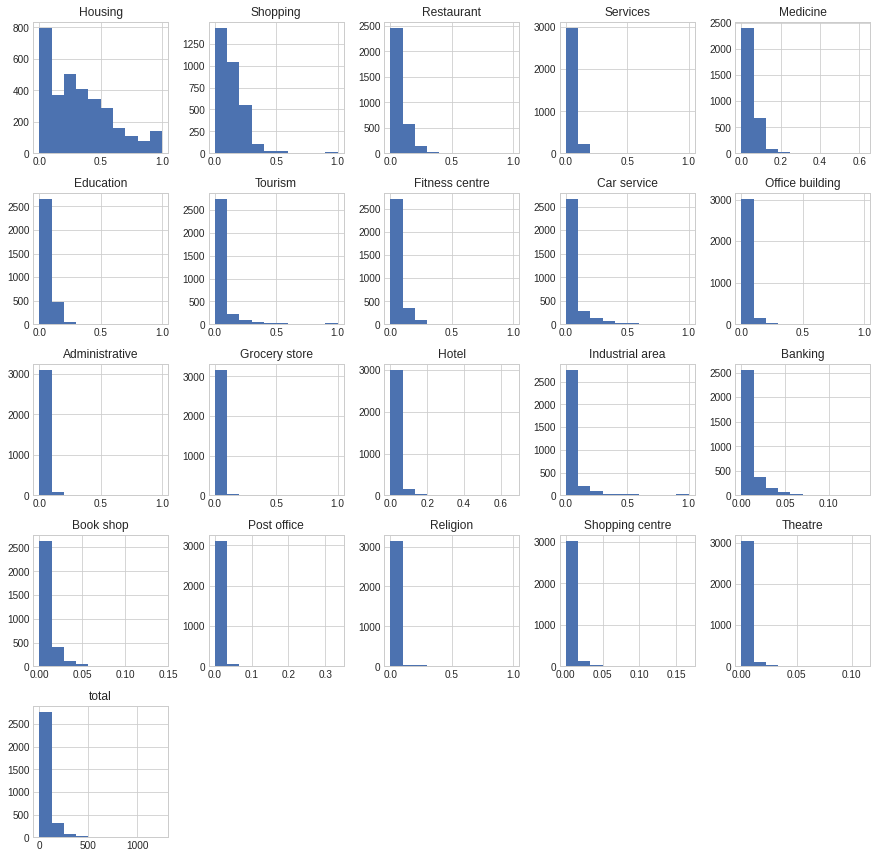

In [11]:
infrastructure_features.hist(figsize=(15, 15));

<AxesSubplot:>

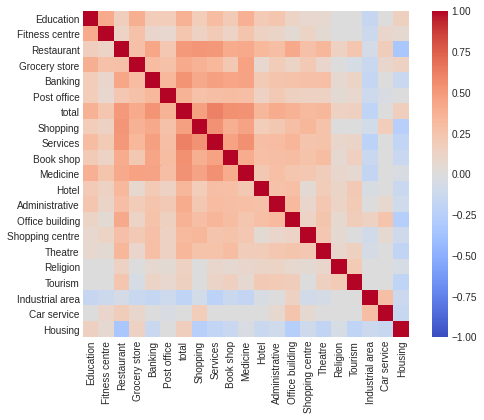

In [12]:
plt.figure(figsize=(8, 6))

corr = corrcoef(infrastructure_features, method='spearman').fillna(0)

sns.heatmap(corr, vmin=-1, cmap='coolwarm', square=True)

In [13]:
total = infrastructure_features['total']

total.head(2)

id
0    601
1    599
Name: total, dtype: int64

In [14]:
quantiles = total.quantile([0, 0.3, 0.5, 0.8, 1])
quantiles

0.0       0.0
0.3      25.0
0.5      48.0
0.8     103.0
1.0    1254.0
Name: total, dtype: float64

In [15]:
def assign_size_cluster(value: float) -> str:
    for i, q in enumerate(quantiles):
        if value <= q:
            return i

size_clusters = total.apply(assign_size_cluster)

size_clusters.head(2)

id
0    4
1    4
Name: total, dtype: int64

In [16]:
coords = supernodes[['lon', 'lat']].values

coords

array([[30.3224152 , 59.85170995],
       [30.28793738, 59.95020979],
       [30.35401882, 59.95671589],
       ...,
       [30.3595223 , 59.9445053 ],
       [30.2344264 , 59.94853172],
       [30.21190075, 59.97198015]])

Text(0.5, 1.0, 'Nodes with different number of attached infrastructure objects')

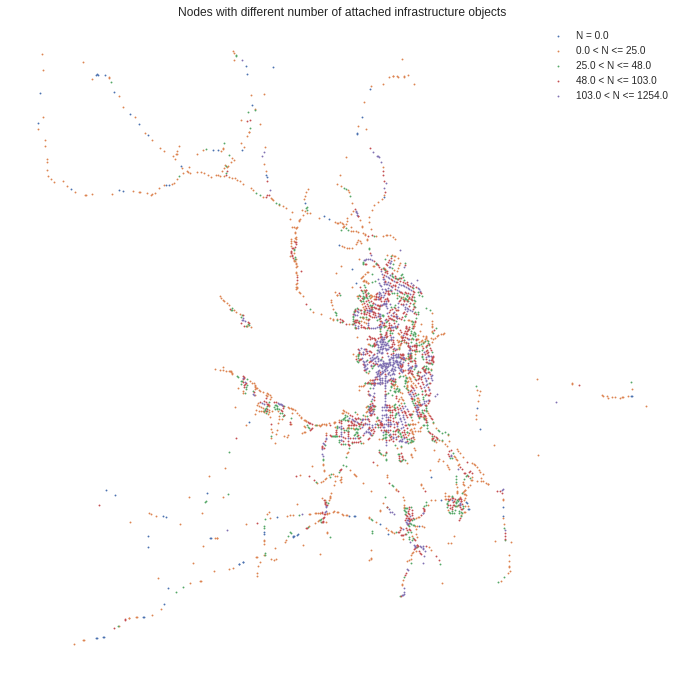

In [17]:
plt.figure(figsize=(12, 12))
plt.axis('off')

for i in sorted(size_clusters.unique()):
    cluster_coords = coords[size_clusters == i]
    
    if i == 0:
        label = f'N = {quantiles.iloc[i]}'
    else:
        label = f'{quantiles.iloc[i - 1]} < N <= {quantiles.iloc[i]}'
        
    plt.scatter(*cluster_coords.T, color=f'C{i}', marker='.', s=3, label=label)

plt.legend()
plt.title('Nodes with different number of attached infrastructure objects')

In [18]:
infrastructure_features_json = []

for _, row in infrastructure_features.reset_index().iterrows():
    row = row.to_dict()
    row['id'] = int(row['id'])
    infrastructure_features_json.append(row)

In [19]:
save_json(infrastructure_features_json, infrastructure_features_fpath)

## Graph features

In [20]:
connected_components = sorted(nx.connected_components(pspace), key=len)

[len(c) for c in connected_components]

[8, 9, 3185]

In [21]:
disconnected_nodes = connected_components[0].union(connected_components[1])

print(disconnected_nodes)

{2916, 2917, 1807, 1808, 2033, 2034, 2035, 2036, 2037, 2038, 3090, 3091, 1809, 1810, 1811, 1812, 1813}


In [22]:
connected = pd.Series({
    node: int(node not in disconnected_nodes)
    for node in pspace
})

connected.value_counts()

1    3185
0      17
dtype: int64

<AxesSubplot:>

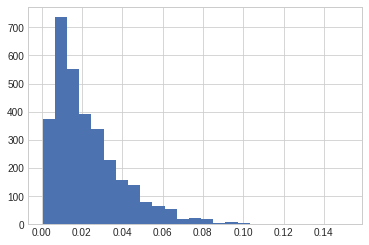

In [23]:
degree_centrality = pd.Series(nx.degree_centrality(pspace))

degree_centrality.hist(bins=25)

CPU times: user 1.36 s, sys: 73.1 ms, total: 1.44 s
Wall time: 1min 29s


<AxesSubplot:>

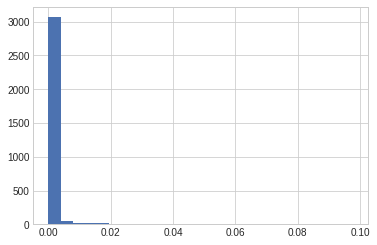

In [24]:
%%time

betweenness_centrality = pd.Series(betweenness_centrality_parallel(pspace, weight='weight'))

betweenness_centrality.hist(bins=25)

CPU times: user 4.25 s, sys: 422 ms, total: 4.68 s
Wall time: 1min 13s


<AxesSubplot:>

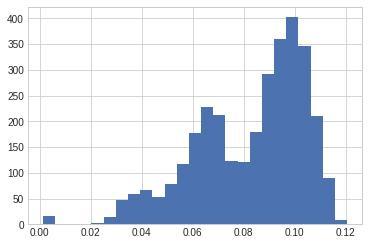

In [25]:
%%time

shortest_path_lengths = pd.DataFrame(shortest_path_lengths_parallel(pspace, weight='weight'))
closeness_centrality_weight = closeness_centrality_parallel(shortest_path_lengths.T)

closeness_centrality_weight.hist(bins=25)

CPU times: user 4.7 s, sys: 378 ms, total: 5.08 s
Wall time: 1min


<AxesSubplot:>

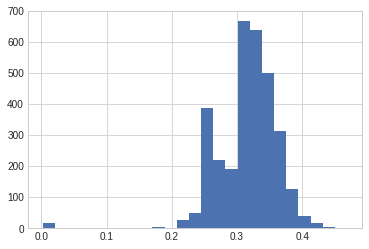

In [26]:
%%time

shortest_path_lengths = pd.DataFrame(shortest_path_lengths_parallel(pspace, weight=None))
closeness_centrality_hops = closeness_centrality_parallel(shortest_path_lengths.T)

closeness_centrality_hops.hist(bins=25)

<AxesSubplot:>

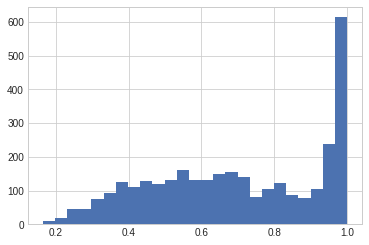

In [27]:
clustering = pd.Series(nx.clustering(pspace))

clustering.hist(bins=25)

<AxesSubplot:>

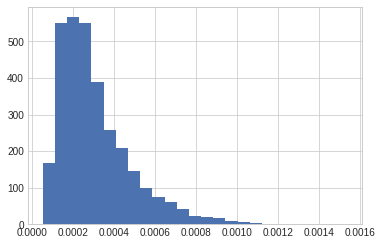

In [28]:
pagerank = pd.Series(nx.pagerank(pspace, weight=None))

pagerank.hist(bins=25)

In [29]:
graph_features = pd.DataFrame({
    'connected': connected,
    'betweenness_centrality': betweenness_centrality,
    'closeness_centrality_weight': closeness_centrality_weight,
    'closeness_centrality_hops': closeness_centrality_hops,
    'degree_centrality': degree_centrality,
    'pagerank': pagerank,
    'clustering': clustering,
    # 'eigenvector_centrality': eigenvector_centrality,
})

graph_features.index.name = 'id'

graph_features.head(2)

,connected,betweenness_centrality,closeness_centrality_weight,closeness_centrality_hops,degree_centrality,pagerank,clustering
id,,,,,,,
0,1,0.097675,0.113412,0.455434,0.124024,0.001454,0.164644
1,1,0.012766,0.114061,0.401304,0.078101,0.000826,0.254800


In [30]:
graph_features.notna().all().all()

True

In [31]:
graph_features.isna().sum()

connected                      0
betweenness_centrality         0
closeness_centrality_weight    0
closeness_centrality_hops      0
degree_centrality              0
pagerank                       0
clustering                     0
dtype: int64

<AxesSubplot:>

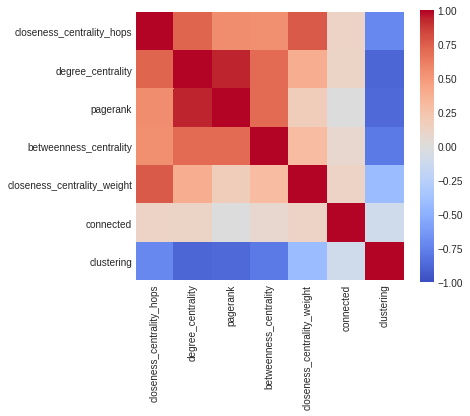

In [32]:
plt.figure(figsize=(6, 5))

corr = corrcoef(graph_features, method='spearman').fillna(0)

sns.heatmap(corr, square=True, vmin=-1, cmap='coolwarm')

In [33]:
all_features = pd.concat([infrastructure_features, graph_features], axis=1)

all_features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,...,Shopping centre,Theatre,total,connected,betweenness_centrality,closeness_centrality_weight,closeness_centrality_hops,degree_centrality,pagerank,clustering
id,,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,...,0.000000,0.0,601,1,0.097675,0.113412,0.455434,0.124024,0.001454,0.164644
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,...,0.001669,0.0,599,1,0.012766,0.114061,0.401304,0.078101,0.000826,0.254800


<AxesSubplot:>

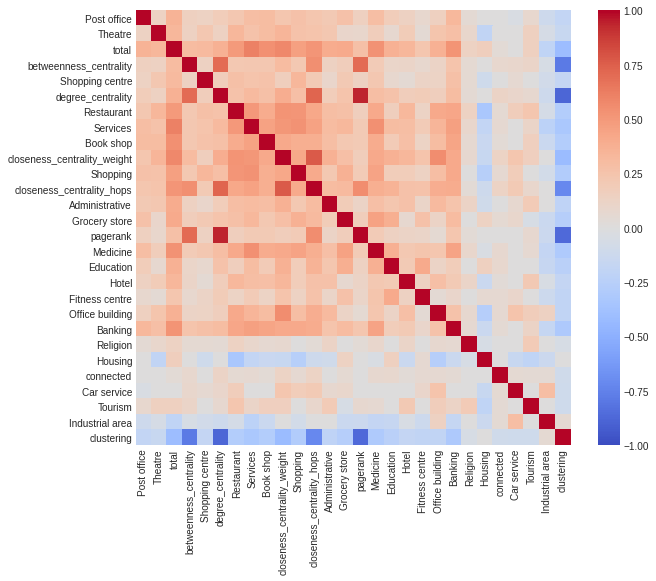

In [34]:
corr = corrcoef(all_features, method='spearman').fillna(0)

plt.figure(figsize=(10, 8))

sns.heatmap(corr, square=True, vmin=-1, cmap='coolwarm')

In [35]:
graph_features_json = []

for i, row in graph_features[sorted(graph_features.columns)].iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    
    graph_features_json.append(item)
    
graph_features_json[0]

{'id': 0,
 'betweenness_centrality': 0.09767493085898474,
 'closeness_centrality_hops': 0.45543432330833483,
 'closeness_centrality_weight': 0.11341202902518127,
 'clustering': 0.1646439203114266,
 'connected': 1.0,
 'degree_centrality': 0.1240237425804436,
 'pagerank': 0.0014543681525720465}

In [36]:
save_json(graph_features_json, graph_features_fpath)